# Project 5 Vehicle Detection

**Author: olala7846@gmail.com**

## Step 1: train a image vehicle classifier

In [1]:
# first do some training data observation
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import random


vehicle_imgs = list(glob.glob('./vehicles/**/*.png'))
nonvehicle_imgs = list(glob.glob('./non-vehicles/**/*.png'))

print('Total %d vehicle images' % len(vehicle_imgs))
print('Total %d non-vehicle images' % len(nonvehicle_imgs))
print('There are about the same size of both classes')

sample_img = random.sample(vehicle_imgs, 1)[0]
img = cv2.imread(sample_img)
print('images has shape', img.shape, 'and dtype', img.dtype)
print('Pixel value range approximately from', np.max(img), 'to', np.min(img))

Total 8792 vehicle images
Total 8968 non-vehicle images
There are about the same size of both classes
images has shape (64, 64, 3) and dtype uint8
Pixel value range approximately from 255 to 1


In [2]:
# Explore different color space
from mpl_toolkits.mplot3d import Axes3D

def plot3d(car_pixels, non_car_pixels):
    """Plot pixels in 3D"""
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)
    
    all_pixels = np.vstack((car_pixels, non_car_pixels))

    # Set axis limits
    ax.set_xlim(np.min(all_pixels[:, 0]), np.max(all_pixels[:, 0]))
    ax.set_ylim(np.min(all_pixels[:, 1]), np.max(all_pixels[:, 1]))
    ax.set_zlim(np.min(all_pixels[:, 2]), np.max(all_pixels[:, 2]))

    ax.scatter(
        car_pixels[:, 0].ravel(),
        car_pixels[:, 1].ravel(),
        car_pixels[:, 2].ravel(),
        c='g', edgecolors='none')

    ax.scatter(
        non_car_pixels[:, 0].ravel(),
        non_car_pixels[:, 1].ravel(),
        non_car_pixels[:, 2].ravel(),
        c='r', edgecolors='none')
    
    return ax

def observe_colorspace():
    sample_car_imgs = random.sample(vehicle_imgs, 100)
    sample_noncar_imgs = random.sample(nonvehicle_imgs, 100)

    convertors = {
        'RGB': cv2.COLOR_BGR2RGB,
        'HLS': cv2.COLOR_BGR2HLS,
        'YUV': cv2.COLOR_BGR2YUV,
        'YCrCb': cv2.COLOR_BGR2YCrCb,
        'Lab': cv2.COLOR_BGR2Lab,
        'Luv': cv2.COLOR_BGR2Luv,
    }

    for name, convertor in convertors.items():
        car_pixels = []
        noncar_pixels = []

        samples_per_pic = 10

        for car_img in sample_car_imgs:
            img = cv2.imread(car_img)
            img = cv2.cvtColor(img, convertor)
            pixels = np.reshape(img, (-1, 3))
            sample_pixels = random.sample(list(pixels), samples_per_pic)
            car_pixels.append(sample_pixels)

        for noncar_img in sample_noncar_imgs:
            img = cv2.imread(noncar_img)
            img = cv2.cvtColor(img, convertor)
            pixels = np.reshape(img, (-1, 3))
            sample_pixels = random.sample(list(pixels), samples_per_pic)
            noncar_pixels.append(sample_pixels)

        car_pixels = np.vstack(car_pixels)
        noncar_pixels = np.vstack(noncar_pixels)

        ax = plot3d(car_pixels, noncar_pixels)
        plt.title(name)
#        # plot different view points
#         for ii in range(0,360,5):
#             ax.view_init(elev=10., azim=ii)
#             plt.savefig("./color_spaces/%s%d.png" % (name, ii))
        
        
observe_colorspace()

### Color space
After tested on mandy color spaces, it's easy to see that some (e.g. RGB, HLS) does a better job seperating vehicle and non-vehicle images. I will choose HLS as the color space for histogram of color.

reading  ./vehicles/GTI_Far/image0000.png


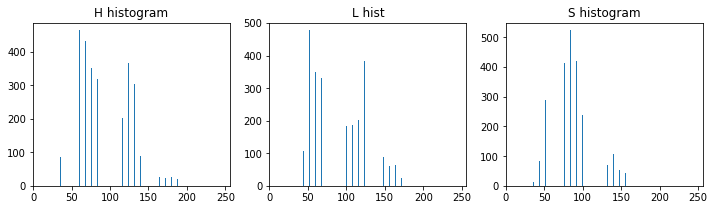

In [11]:
# Extact color histogram features
def color_hist(img, nbins=32, bins_range=(0, 256), cvt_color=None, visualize=False):
    if cvt_color:
        img = cv2.cvtColor(img, cvt_color)
    hist0 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    hist1 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    hist2 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    if visualize:
        return hist0, hist1, hist2
    else:
        return np.concatenate((hist0[0], hist1[0], hist2[0]))
    
img_name = vehicle_imgs[0]
print('reading ', img_name)
img = cv2.imread(vehicle_imgs[0])
hist1, hist2, hist3 = color_hist(img, cvt_color=cv2.COLOR_BGR2RGB, visualize=True)

# visualize histogram
bin_edges = hist1[1]
bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2

fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(bin_centers, hist1[0])
plt.xlim(0, 256)
plt.title('H histogram')
plt.subplot(132)
plt.bar(bin_centers, hist2[0])
plt.xlim(0, 256)
plt.title('L hist')
plt.subplot(133)
plt.bar(bin_centers, hist3[0])
plt.xlim(0, 256)
plt.title('S histogram')
plt.show()

In [16]:
# Spatial bin
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    convertors = {
        'RGB': cv2.COLOR_BGR2RGB,
        'HLS': cv2.COLOR_BGR2HLS,
        'YUV': cv2.COLOR_BGR2YUV,
        'YCrCb': cv2.COLOR_BGR2YCrCb,
        'Lab': cv2.COLOR_BGR2Lab,
        'Luv': cv2.COLOR_BGR2Luv,
    }
    convertor = convertors[color_space]
    feature_img = cv2.cvtColor(img, convertor)
    features = cv2.resize(feature_img, size).ravel()
    return features


In [18]:
# Prepare training data
from sklearn.preprocessing import StandardScaler

def extract_features(img):
    img = cv2.imread(img)
    color_hist_features = color_hist(img)
    bin_spatial_features = bin_spatial(img)
    
    return np.concatenate((color_hist_features, bin_spatial_features))

car_features = np.array([extract_features(img) for img in vehicle_imgs])
noncar_features= np.array([extract_features(img) for img in nonvehicle_imgs])

# define labels
X = np.vstack((car_features, noncar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)),
               np.zeros(len(noncar_features))))

print(X.shape, y.shape)

[[   0.    0.    0. ...,  161.  161.  142.]
 [   0.    0.    0. ...,  162.  158.  144.]
 [   0.    0.    0. ...,  190.  189.  176.]
 ..., 
 [   0.    0.    0. ...,  154.  153.  135.]
 [   0.    0.    0. ...,  144.  145.  129.]
 [   0.    0.    0. ...,  123.  129.  115.]] [ 1.  1.  1. ...,  0.  0.  0.]


In [22]:
# train classifier with SVM
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

svc = LinearSVC()
svc.fit(X_train, y_train)

print('Test Accuracy of SVC = ', svc.score(X_test, y_test))

Test Accuracy of SVC =  0.953828828829


## Classifier
We get 0.9538 accuracy only using color features!


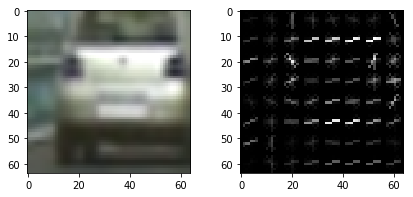

In [32]:
# hog features
from skimage.feature import hog

def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=False):
    return hog(
        img, orient, 
        pixels_per_cell=(pix_per_cell, pix_per_cell),
        cells_per_block=(cell_per_block, cell_per_block),
        visualise=vis, feature_vector=feature_vec)


img = cv2.imread(vehicle_imgs[100])
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
features, hog_image = get_hog_features(gray, vis=True)
fig = plt.figure(figsize=(7,3))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.show()

In [6]:

# Feature extraction
# TODO(Olala)
# 1. observe data
# 2. extract features
#     2.1 histogram on color space
#     2.2 HOG features
# 3. train classifier
#     3.1 train test split
#     3.2 test on different classifier parameters
#     3.3 choose the best
# 4. sliding window search
#     4.1 sliding window with HOG features
#     4.2 different sliding window size
#     4.3 reduce false positive using heatmap
# 5. run pipeline on video
#     5.1 create detection pipeline
#     5.2 reduce false positive using series of frames
# 6. write report

